Model Değerlendirme Script'i Başlatıldı.
'all_trained_models_kucuk_2class_glcm_best_params.pkl' dosyasından eğitilmiş modeller yükleniyor...
'hog_color_lbp_glcm_augmented_test_kucuk_2class.pkl' dosyasından test verisi yükleniyor...
Test verisi ölçeklendiriliyor ve PCA dönüşümü uygulanıyor...

Veriler başarıyla yüklendi ve hazırlandı. Değerlendirme başlıyor...

===== 'SVM' MODELİ DEĞERLENDİRME SONUÇLARI =====

--- SINIFLANDIRMA RAPORU ---
              precision    recall  f1-score   support

        bird       0.96      0.89      0.92       570
       drone       0.95      0.98      0.96      1128

    accuracy                           0.95      1698
   macro avg       0.95      0.94      0.94      1698
weighted avg       0.95      0.95      0.95      1698

--- KARIŞIKLIK MATRİSİ ---


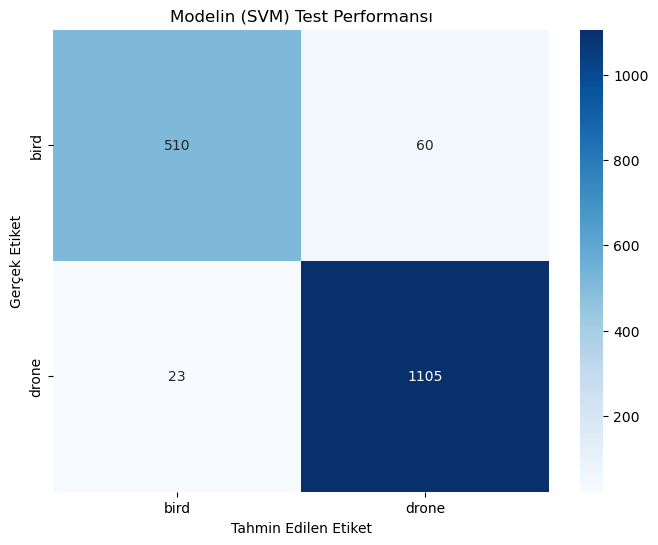


===== 'MLP' MODELİ DEĞERLENDİRME SONUÇLARI =====

--- SINIFLANDIRMA RAPORU ---
              precision    recall  f1-score   support

        bird       0.95      0.88      0.91       570
       drone       0.94      0.98      0.96      1128

    accuracy                           0.94      1698
   macro avg       0.94      0.93      0.94      1698
weighted avg       0.94      0.94      0.94      1698

--- KARIŞIKLIK MATRİSİ ---


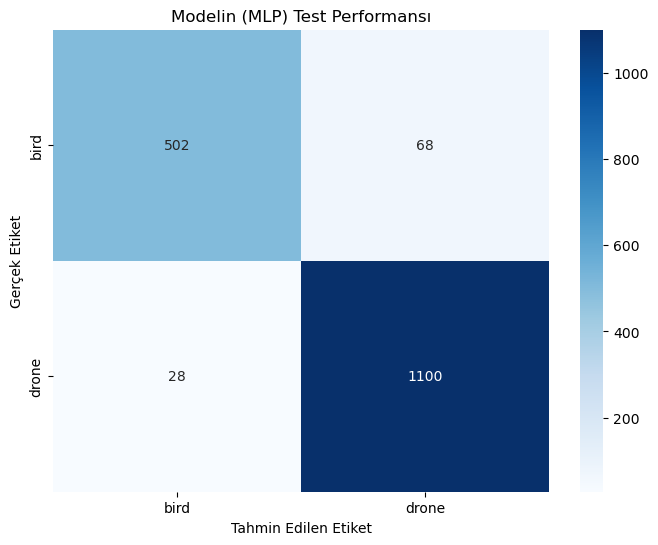


===== 'XGBoost' MODELİ DEĞERLENDİRME SONUÇLARI =====

--- SINIFLANDIRMA RAPORU ---
              precision    recall  f1-score   support

        bird       0.96      0.83      0.89       570
       drone       0.92      0.98      0.95      1128

    accuracy                           0.93      1698
   macro avg       0.94      0.91      0.92      1698
weighted avg       0.93      0.93      0.93      1698

--- KARIŞIKLIK MATRİSİ ---


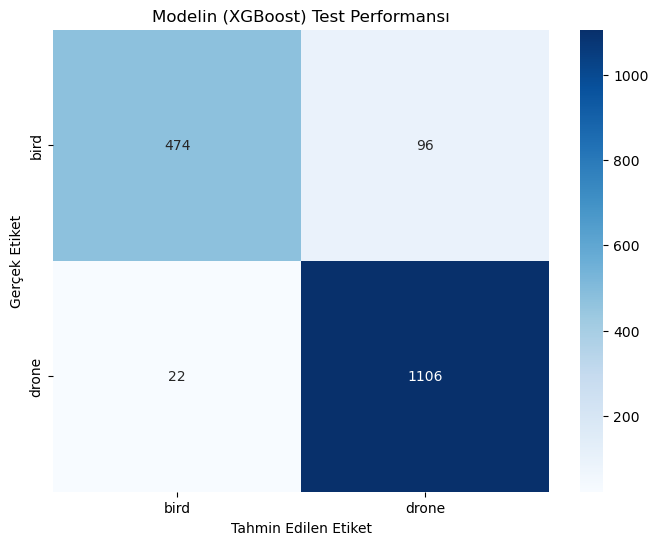


Tüm modellerin değerlendirilmesi 7.06 saniye sürdü.

Değerlendirme tamamlandı!


In [2]:
# Gerekli kütüphaneleri projemize dahil ediyoruz
import joblib
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import warnings
from sklearn.exceptions import InconsistentVersionWarning

# Olası kütüphane versiyon uyumsuzluğu uyarılarını gizle
warnings.filterwarnings("ignore", category=InconsistentVersionWarning)

# --- Gerekli Dosyaların ve Değişkenlerin Tanımlanması ---
# DEĞERLENDİRİLECEK MODELLERİN DOSYASI
# --- Gerekli Dosyaların ve Değişkenlerin Tanımlanması ---
### DEĞİŞTİRİLDİ: Doğru model ve test dosyası adları yazıldı ###
MODELS_FILE = 'all_trained_models_kucuk_2class_glcm_best_params.pkl'
# Model GLCM ile eğitildiği için, test verisi de GLCM içermelidir.
TEST_FEATURES_FILE = 'hog_color_lbp_glcm_augmented_test_kucuk_2class.pkl'

print("Model Değerlendirme Script'i Başlatıldı.")

# --- Dosya Kontrolleri ---
if not os.path.exists(MODELS_FILE):
    print(f"HATA: Değerlendirilecek model dosyası bulunamadı -> '{MODELS_FILE}'")
    exit()
if not os.path.exists(TEST_FEATURES_FILE):
    print(f"HATA: Test verisi dosyası bulunamadı -> '{TEST_FEATURES_FILE}'")
    exit()

# =================================================================================
# FAZ A: MODEL VE TEST VERİSİNİ YÜKLEME
# =================================================================================
print(f"'{MODELS_FILE}' dosyasından eğitilmiş modeller yükleniyor...")
saved_data = joblib.load(MODELS_FILE)
trained_models = saved_data['models']
scaler = saved_data['scaler']
pca = saved_data['pca']
le = saved_data['le']
class_names = saved_data['class_names']

print(f"'{TEST_FEATURES_FILE}' dosyasından test verisi yükleniyor...")
test_data = joblib.load(TEST_FEATURES_FILE)
X_test, y_test_text = test_data['features'], test_data['labels']

# Etiketleri sayısal formata çevir
y_test = le.transform(y_test_text)

# Test verisini, modellerin eğitildiği şekilde ön işleme sok
print("Test verisi ölçeklendiriliyor ve PCA dönüşümü uygulanıyor...")
X_test_scaled = scaler.transform(X_test)
X_test_pca = pca.transform(X_test_scaled)

print("\nVeriler başarıyla yüklendi ve hazırlandı. Değerlendirme başlıyor...")
start_time = time.time()

# =================================================================================
# FAZ B: MODELLERİ TÜM TEST SETİ ÜZERİNDE DEĞERLENDİRME
# =================================================================================

# Kaydedilmiş her bir model için döngü
for model_name, model in trained_models.items():
    print(f"\n===== '{model_name}' MODELİ DEĞERLENDİRME SONUÇLARI =====")
    
    # 1. Tahminleri Yap
    y_pred = model.predict(X_test_pca)
    
    # 2. Sınıflandırma Raporunu Yazdır
    print("\n--- SINIFLANDIRMA RAPORU ---")
    print(classification_report(y_test, y_pred, target_names=class_names))
    
    # 3. Karışıklık Matrisini Çizdir
    print("--- KARIŞIKLIK MATRİSİ ---")
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Modelin ({model_name}) Test Performansı')
    plt.ylabel('Gerçek Etiket')
    plt.xlabel('Tahmin Edilen Etiket')
    plt.show()

end_time = time.time()
print(f"\nTüm modellerin değerlendirilmesi {end_time - start_time:.2f} saniye sürdü.")
print("\nDeğerlendirme tamamlandı!")